# Tonga Volcano Eruption - SO2 Analysis

From December 20th, 2021, a volcanic eruption began on `Hunga Tonga–Hunga Ha'apai`, a submarine volcano in the Tongan archipelago in the southern Pacific Ocean. Nearly four weeks later, the eruption reached a very large and powerful climax (at around January 15th, 2022). Location-wise, `Hunga Tonga–Hunga Ha'apai` is 65 km (~40 mi) north of Tongatapu, the country's main island, and is part of the highly active `Tonga–Kermadec Islands volcanic arc`, a subduction zone extending from New Zealand north-northeast to Fiji. The eruption caused tsunamis in Tonga, Fiji, American Samoa, Vanuatu, and along the Pacific rim, including damaging tsunamis in New Zealand, Japan, the United States, the Russian Far East, Chile, and Peru. Named as "hundreds of times more powerful" than the atomic bomb dropped on Hiroshima by NASA [[1]](./tonga_volcano_eruption_2022.ipynb#Reference), the event was probably the largest volcanic eruption in the 21st century, and the largest recorded since 1991. 

A satellite animation from [Wikipedia (Image collected by Himawari-8)](https://en.wikipedia.org/wiki/2022_Hunga_Tonga%E2%80%93Hunga_Ha%27apai_eruption_and_tsunami) showed a massive explosion with a lot of smoke.

![Satellite animation of the eruption on Hunga Tonga–Hunga Ha'apai on Jan 15, 2022. Image from Wikipedia](https://miro.medium.com/max/960/1*evpCJ-6NT8SKcbZM5KqxGQ.gif)

## Read the event from feeds

First, we need to run a set of commands to parse the `NASA's EONET Feeds` [[2]](./tonga_volcano_eruption_2022.ipynb#Reference), in order to grasp volcano eruptions happening worldwide, and the detailed information for the Tonga Volcano eruption.

In [1]:
import json
from arcgis.geometry import Geometry
import requests
import pandas as pd
from arcgis.features import Feature, FeatureSet, FeatureCollection, GeoAccessor
from arcgis.gis import GIS
from arcgis.mapping import MapImageLayer
from arcgis.geometry import Point
from arcgis.geometry.functions import buffer

In [2]:
""" read the response from HTTP request, and load as JSON object;
    all "events" in original JSON will be stored as "features"
"""
response = requests.get("https://eonet.gsfc.nasa.gov/api/v3/events/geojson?category=Volcanoes,earthquakes&start=2019-12-01&end=2022-11-30&status=closed")  
obj = json.loads(response.text)

In [3]:
fset = FeatureSet.from_geojson(obj)
fc = FeatureCollection.from_featureset(fset, symbol=None, 
                                       name="Natural Disaster Feed Events Feature Collection")
fc.query()

<FeatureSet> 145 features

In [4]:
df = fc.query().sdf
# drop unnecessary columns
cols = [col for col in df.columns if col not in ['OBJECTID', 'SHAPE', 'link', 'index', 'sources']]

df3 = df[cols]
df3 = df3[df3['title'].str.contains("Tonga") == True]

In [5]:
df3

,id,title,description,closed,date,magnitudeValue,magnitudeUnit,categories
5,EONET_6253,"Home Reef Volcano, Tonga",None,2022-10-20T00:00:00Z,2022-09-10T00:00:00Z,None,None,"[{'id': 'volcanoes', 'title': 'Volcanoes'}]"
47,EONET_5985,"Hunga Tonga-Hunga Ha&#039;apai Volcano, Tonga",None,2022-01-22T00:00:00Z,2021-12-21T00:00:00Z,None,None,"[{'id': 'volcanoes', 'title': 'Volcanoes'}]"


In [10]:
# The most related search result from above
df3[1]

,index,id,title,date,link,source_id,source_url
0,20,EONET_5985,"Hunga Tonga-Hunga Ha'apai Volcano, Tonga",2021-12-21T00:00:00Z,https://eonet.gsfc.nasa.gov/api/v2.1/events/EONET_5985,SIVolcano,https://volcano.si.edu/volcano.cfm?vn=243040


In [6]:
map_g = GIS().map()


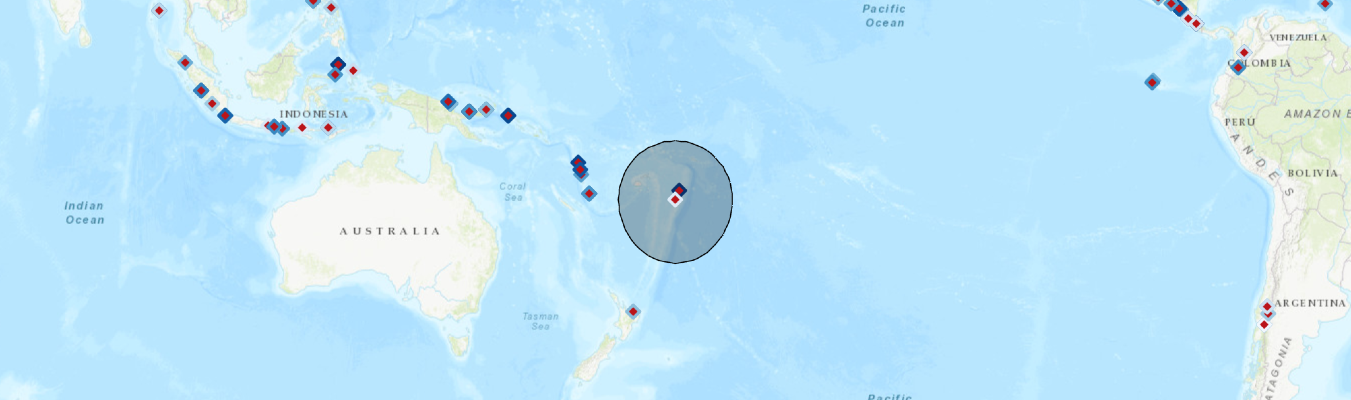

In [11]:
# Global volcano eruptions from end of year 2019 till now
map_g.clear_graphics()
map_g.remove_layers()
map_g

Per information provided in the EONet Feed, Tonga Volcano Eruption site is located as a point geometry in the [feed entry](https://eonet.gsfc.nasa.gov/api/v2.1/events/EONET_5985). We can now create a Point geometry, and draw the buffered area in the map.

In [8]:
pt = Point({"x" : -175.382, "y" : -20.536, 
            "spatialReference" : {"wkid" : 4326}})

In [9]:
pt_buffered = pt.buffer(distance=10)
map_g.draw(pt_buffered)

In [10]:
# Filter based on disaster type, and each type is assigned a different symbology
for ea in fc.query():
    
    title = ea.get_value('title')
    obj_id = ea.attributes['OBJECTID']
    obj_type = ea.geometry_type
    
    if "Volcano" in title and obj_type == 'Point':
        df_sel = df[df['OBJECTID']==obj_id]
        df_sel.spatial.plot(map_widget= map_g,
                            name=title,
                            renderer_type='s',
                            symbol_type='simple',
                            symbol_style='d', # d - for diamonds
                            colors='Reds_r',
                            cstep=50,
                            outline_color='Blues',
                            marker_size=10)
    elif "quake" in title and obj_type == 'Point':
        df_sel = df[df['OBJECTID']==obj_id]
        df_sel.spatial.plot(map_widget= map_g,
                            name=title,
                            renderer_type='s',
                            symbol_type='simple',
                            symbol_style='+', # + - for crosses
                            colors='khaki',
                            cstep=50,
                            outline_color='Blues',
                            marker_size=10)

## Visualize the extent of damage

Next, we can further look into the Tonga Volcanic Eruption with different informational layers, e.g. the `Magnitudes and Shake Intensities of Recent Earthquakes`, `Significant Global Volcanic Eruptions`, and `Sea Floor Crustal Age`.

In [12]:
gis = GIS(profile="your_online_profile")

In [13]:
from arcgis.mapping import WebMap
webmap = gis.content.get("e0abd2028f4043d89a4a907674d270ff")


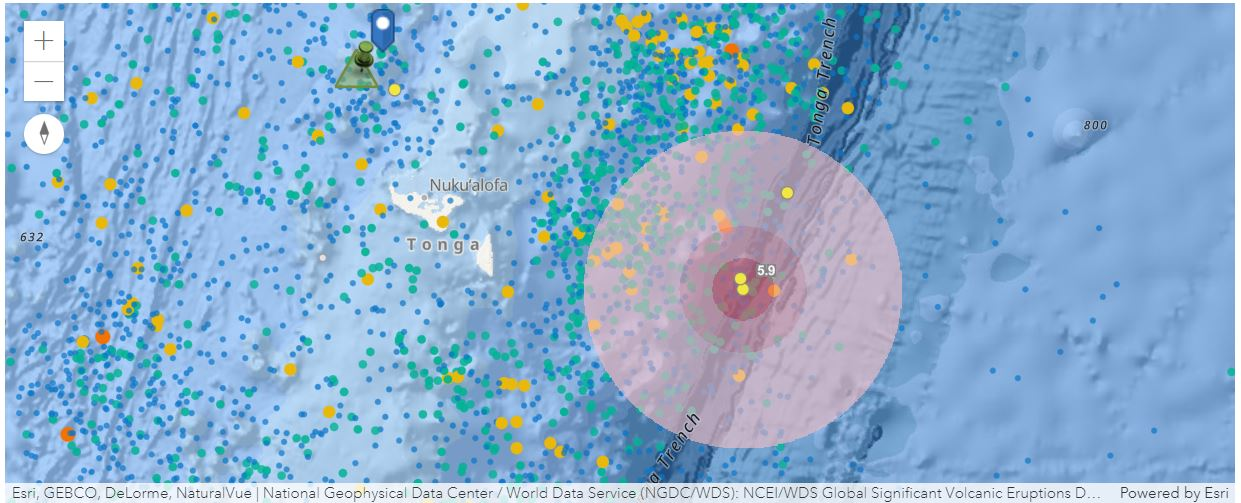

In [113]:
wm_obj = WebMap(webmap)
wm_obj

Details about layers being shown below:

(1) Recent Earthquakes
 - This service presents recent earthquake information from the USGS Prompt Assessment of Global Earthquakes for Response (PAGER) program.
 - In addition to displaying earthquakes by magnitude, this service also provide earthquake impact details. Impact is measured by population as well as models for economic and fatality loss. For more details, see: [PAGER Alerts](https://earthquake.usgs.gov/earthquakes/pager).

  - Events are updated as frequently as every 5 minutes and are available up to 30 days with the following exceptions:
  - Events with a Magnitude LESS than 3.0 are retained for 3 days
  - Events with a Magnitude LESS than 4.5 are retained for 7 days
  
 - In addition to event points, ShakeMaps are also provided. These have been dissolved by Shake Intensity to reduce the Layer Complexity.
 - The specific layers provided in this service have been Time Enabled and include:
  - Events by Magnitude: The event’s seismic magnitude value.
    - Contains PAGER Alert Level: USGS PAGER (Prompt Assessment of Global Earthquakes for Response) system provides an automated impact level assignment that estimates fatality and economic loss.
    - Contains Significance Level: An event’s significance is determined by factors like magnitude, max MMI, ‘felt’ reports, and estimated impact.
  - Shake Intensity: The Instrumental Intensity or Modified Mercalli Intensity (MMI) for available events.


(2) Significant Global Volcanic Eruptions
 - This feature layer, utilizing data from the National Oceanic and Atmospheric Administration (NOAA), displays global locations of significant volcanic eruptions. A significant eruption is classified as one that meets at least one of the following criteria: 
  - Caused fatalities
  - Caused moderate damage (approximately 1 million or more)
  - Has a Volcanic Explosivity Index (VEI) of 6 or larger 
  - Caused a tsunami
  - Was associated with a major earthquake
  
  
(3) Sea Floor Crustal Age:
 - Scientists use the magnetic polarity of the sea floor to determine the age. Very little of the sea floor is older than 150 million years. This is because the oldest sea floor is subducted under other plates and replaces by new surfaces. The tectonic plates are constantly in motion and new crust is always being created. This continual motion is evidenced by the occurrence of earthquakes and volcanoes. Data accessed from [here](https://www.ngdc.noaa.gov/mgg/ocean_age/ocean_age_2008.html).

In [14]:
# Recent Earthquakes
quake = gis.content.get("9e2f2b544c954fda9cd13b7f3e6eebce")
# Significant Global Volcanic Eruptions
erupt = gis.content.get("3318aafcd304414bb8da481d173c551d")
# sea floor crustal age
seafloor = gis.content.get("aa1c10c58c894467a1ade5a43ed70c19")

Use the `side_by_side` method defined below to display these four informational maps regarding Tonga Volcano eruption, and note that, `sync_navigation` is used here to display the four maps in a synchronous manner reacting to zoom in/out and drag/drop.

In [19]:
from ipywidgets import *
from arcgis.geocoding import geocode

def side_by_side(address, item2, item3, item4, item1="satellite", 
                 label2="Recent earthquakes", label3="Significant eruptions",
                 label4="Sea Floor Crustal Age"):
    location = geocode(address)[0]

    satmap1 = gis.map(location)
    satmap1.basemap = item1

    satmap2 = gis.map(location)
    satmap2.add_layer(item2)

    satmap1.layout=Layout(flex='1 1', padding='6px', height='450px')
    satmap2.layout=Layout(flex='1 1', padding='6px', height='450px')

    label1 = HBox([Label("Satellite"), Label(label2)])
    box1 = HBox([satmap1, satmap2])
    
    # set hbox layout preferences
    hbox_layout = Layout()
    hbox_layout.justify_content = 'space-around'
    label1.layout = hbox_layout
    
    # sync left and right maps
    satmap1.sync_navigation(satmap2)
    
    satmap3 = gis.map(location)
    satmap3.add_layer(item3)

    satmap4 = gis.map(location)
    satmap4.add_layer(item4)

    satmap3.layout=Layout(flex='1 1', padding='6px', height='450px')
    satmap4.layout=Layout(flex='1 1', padding='6px', height='450px')

    label2 = HBox([Label(label3), Label(label4)])
    box2 = HBox([satmap3, satmap4])
    label2.layout = hbox_layout
    
    # sync left and right maps
    satmap1.sync_navigation(satmap3)
    satmap3.sync_navigation(satmap4)
    
    return VBox([label1, box1, label2, box2])


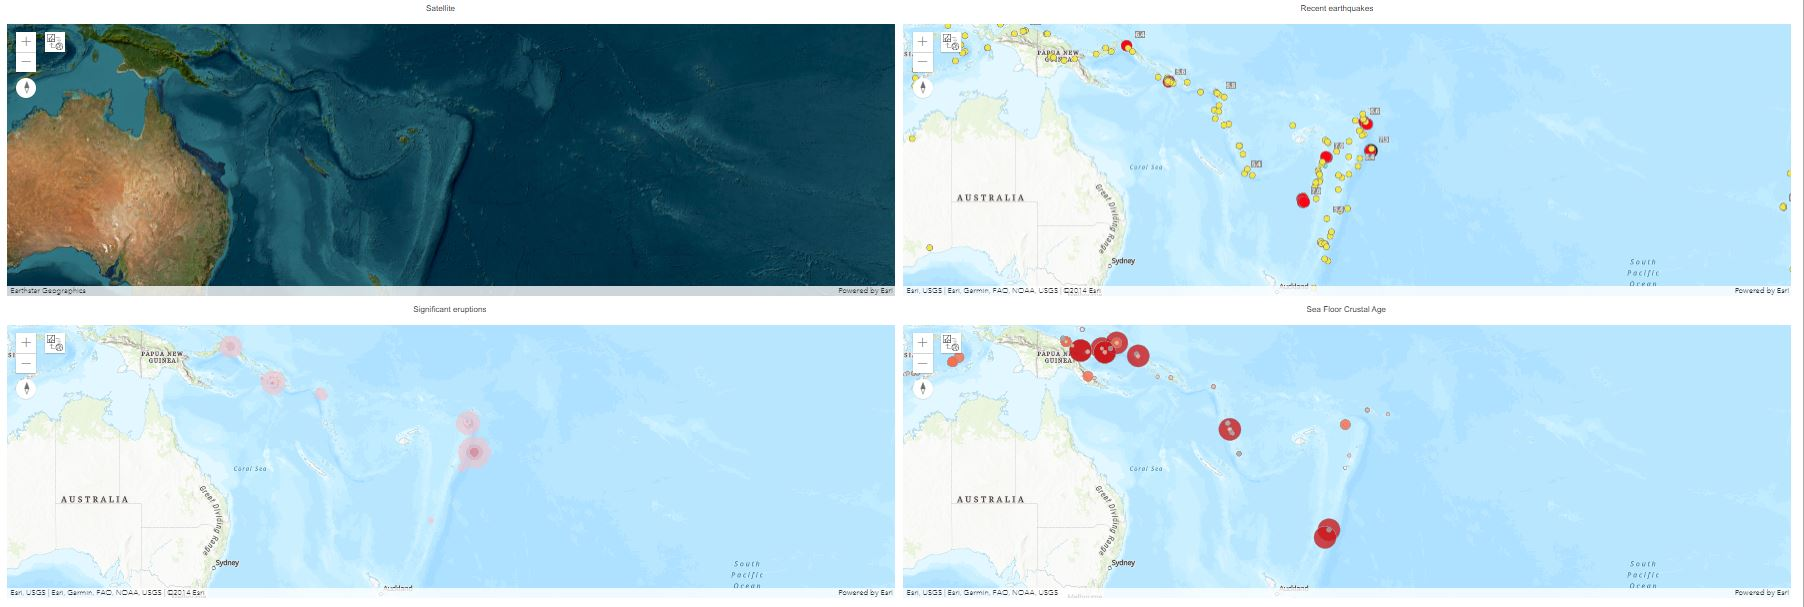

In [21]:
side_by_side("Hunga Tonga–Hunga Ha'apai", quake.layers[0], quake.layers[1], erupt)

## Remote Sensing and Image Processing

### Visual Assessment (Select before and after rasters)

A way to visually assess the damage caused by the volcano eruption is from comparing the before- and after-eruption images side by side. However, the high-resolution imagery services covering the area are not easily accessible publicly. Just for demonstration purposes, we will now look at two sample imagery provided by `Maxar`'s `Open Data Program` (To support the humanitarian community, [Maxar](https://blog.maxar.com/for-a-better-world/2022/open-data-response-to-the-volcano-eruption-in-tonga?utm_source=blog&utm_medium=organic&utm_campaign=tonga-water-analysis) publicly releases data of the affected areas to support response efforts as part of their [OPEN DATA PROGRAM](https://www.maxar.com/open-data/tonga-volcano?utm_source=blog&utm_medium=organic&utm_campaign=odp-tonga-volcano)).

Follow the instructions in [OPEN DATA PROGRAM](https://www.maxar.com/open-data/tonga-volcano?utm_source=blog&utm_medium=organic&utm_campaign=odp-tonga-volcano) to download the before- and after- disaster images into your local download path, e.g. `"<Your download folder>"`.

In [5]:
l_path = r"<Your download folder>\10_homes-and-buildings-before-main-eruption_29dec2021_wv2.jpg"
r_path = r"<Your download folder>\11_ash-covered-homes-and-buildings-after-main-eruption_18jan2022_wv2.jpg"

Then use the `side_by_side2` method defined below to initialize the raster images into a `Raster` data object, and set the two images up for display side-by-side.

In [3]:
import numpy
import matplotlib.pyplot as plt
from arcgis.raster import Raster

In [4]:
def side_by_side2(address, raster1, raster2, r_extent, opa=1):
    location = geocode(address)[0]

    satmap1 = gis.map(location)
    item1 = Raster(raster1, extent=r_extent, opacity = opa)
    satmap1.add_layer(item1)

    satmap2 = gis.map(location)
    item2 = Raster(raster2, extent=r_extent, opacity = opa)
    satmap2.add_layer(item2)

    satmap1.layout=Layout(flex='1 1', padding='6px', height='450px')
    satmap2.layout=Layout(flex='1 1', padding='6px', height='450px')

    box = HBox([satmap1, satmap2])
    
    return box


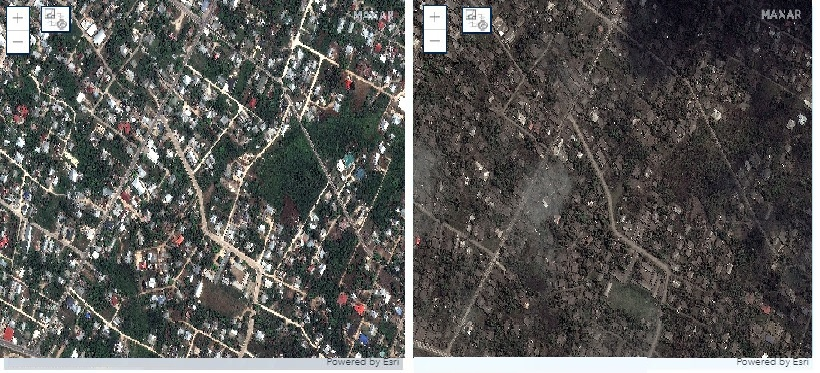

In [10]:
extent = {"xmin":-175.38255,
          "ymin":-20.536216,
          "xmax":-175.38244,
          "ymax":-20.536941,
          "spatialReference":{"wkid":4326}
         }
side_by_side2("Hunga Tonga–Hunga Ha'apai", 
              l_path,
              r_path,
              r_extent=extent)

### SO2 Analysis

Tonga's `Hunga-Tonga-Hunga-Ha'apai volcano` erupted on Saturday, January 15, 2022, with a huge plume of ash, gas and steam that spewed up to 13 miles into the atmosphere. The mushroom-like cloud covered the entire South Pacific Island kingdom and the tsunami that coastal areas experienced was frightening for many but rose 3 feet (80 centimeters), allowing most to escape. The smoke people saw naturally consists of water vapor, carbon dioxide (CO2), sulfur dioxide (SO2), and ash.

After being released, SO2 is converted to sulfate aerosols at a high altitude. The aerosols are able to reflect sunlight and cool the Earth’s climate, and they are also a cause of ozone depletion. With massive eruptions, SO2 can be injected more than 10 km into the atmosphere. However, the released SO2 is hard to observe due to its invisibility. Now, let's explore how we can visualize SO2 movement after the eruption with a scatter plot and heat map.

<b>Note:</b> The follow procedures require the use of `seaborn`, `h5py` and `imageio` packages. If not installed previously, please run the following lines to start the installation:

In [ ]:
!pip install seaborn

In [ ]:
!pip install h5py

In [ ]:
!pip install imageio

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

%matplotlib inline

#### Getting the data

`NASA`'s Goddard Earth Sciences Data and Information Services Center ([GES DISC](https://disc.gsfc.nasa.gov/)) has provided free access (and downloads) of the world-wide atmospheric composition data, including SO2, at its [portal](https://disc.gsfc.nasa.gov/data-access). <b>Note:</b> the data is only downloadable after user sign-up [[2]](./tonga_volcano_eruption_2022.ipynb#Reference).

We are going to derive the SO2 data from the [OMPS_NPP_NMSO2_PCA_L2 data product](https://disc.gsfc.nasa.gov/datasets/OMPS_NPP_NMSO2_PCA_L2_2/summary), which is a Level 2 orbital-track volcanic and anthropogenic sulfur dioxide product for the Ozone Mapping and Profiler Suite (OMPS) [Nadir Mapper (NM)](https://ozoneaq.gsfc.nasa.gov/omps/) onboard the NASA/NOAA Suomi National Polar-orbiting Partnership (SNPP) satellite [[5, 7]](./tonga_volcano_eruption_2022.ipynb#Reference).

When making temporal selections to the search, make sure to choose from <b>January 12th to 23rd</b> since the eruption of `Hunga Tonga–Hunga Ha'apai` reached its climax on January 15, 2022, and normally the decay period is around 10 days. When getting data, we will be instructed by the portal to download a text file (.txt), which can not only be used in the scripted downloading process, but it will also help us obtain a list of the file names in the next cell. The step-by-step instructions on how to use `wget` to download data into one's Windows and `curl` to Mac or Linux environment can be found in the [NASA GSFC's instruction page](https://disc.gsfc.nasa.gov/data-access).

Now, assuming that we have followed the instructions to register for a new account, select required data for downloads, and have the download script (.txt) ready as in `"<Your download folder>\5608382643-download.txt"`, let's get to analysis and visualizaiton:

In [47]:
f = open(r"<Your download folder>\5608382643-download.txt", 'r')
files = [i.split('/')[-1] for i in f.read().split('\n')[1:]]
files[0:5]

['OMPS-NPP_NMSO2-PCA-L2_v2.0_2022m0121t013510_o53029_2022m0121t032654.h5',
 'OMPS-NPP_NMSO2-PCA-L2_v2.0_2022m0120t015409_o53015_2022m0120t031149.h5',
 'OMPS-NPP_NMSO2-PCA-L2_v2.0_2022m0120t001239_o53014_2022m0120t020358.h5',
 'OMPS-NPP_NMSO2-PCA-L2_v2.0_2022m0119t104039_o53006_2022m0119t142205.h5',
 'OMPS-NPP_NMSO2-PCA-L2_v2.0_2022m0119t003139_o53000_2022m0119t032954.h5']

##### Using XArray

<b>Note:</b> The follow procedures require the use of `xarray`, `netCDF4` and `h5netcdf` packages. If not installed previously, please run the following lines to start the installation:

In [ ]:
!pip install xarray

In [ ]:
!pip install netCDF4

In [ ]:
!pip install h5netcdf 

In [1]:
import xarray as xr
import netCDF4

In [21]:
location_data = [xr.open_dataset(r'<Your download folder>' + '/' + file, 
                                 group="GEOLOCATION_DATA", engine="h5netcdf") for file in files]
location_data[0]

<xarray.Dataset>
Dimensions:              (nTimes: 400, nXtrack: 36, nCorners: 4)
Dimensions without coordinates: nTimes, nXtrack, nCorners
Data variables: (12/13)
    Latitude             (nTimes, nXtrack) float32 ...
    LatitudeCorner       (nTimes, nXtrack, nCorners) float32 ...
    Longitude            (nTimes, nXtrack) float32 ...
    LongitudeCorner      (nTimes, nXtrack, nCorners) float32 ...
    SolarAzimuthAngle    (nTimes, nXtrack) float32 ...
    SolarZenithAngle     (nTimes, nXtrack) float32 ...
    ...                   ...
    SpacecraftLatitude   (nTimes) float32 ...
    SpacecraftLongitude  (nTimes) float32 ...
    Time                 (nTimes) datetime64[ns] ...
    UTC_CCSDS_A          (nTimes) |S27 ...
    ViewingAzimuthAngle  (nTimes, nXtrack) float32 ...
    ViewingZenithAngle   (nTimes, nXtrack) float32 ...

In [38]:
location_data[0].groupby("Time").mean()

<xarray.Dataset>
Dimensions:              (Time: 400, nXtrack: 36, nCorners: 4)
Coordinates:
  * Time                 (Time) datetime64[ns] 2022-01-21T01:35:20.882614912 ...
Dimensions without coordinates: nXtrack, nCorners
Data variables:
    Latitude             (Time, nXtrack) float32 -71.63 -72.44 ... 69.16 68.55
    LatitudeCorner       (Time, nXtrack, nCorners) float32 -70.42 ... 69.33
    Longitude            (Time, nXtrack) float32 10.61 4.991 ... 171.1 175.4
    LongitudeCorner      (Time, nXtrack, nCorners) float32 14.19 7.252 ... 173.1
    SolarAzimuthAngle    (Time, nXtrack) float32 150.4 155.6 ... -157.0 -153.0
    SolarZenithAngle     (Time, nXtrack) float32 85.68 85.75 ... 90.83 90.92
    SpacecraftAltitude   (Time) float32 8.544e+05 8.545e+05 ... 8.375e+05
    SpacecraftLatitude   (Time) float32 -71.73 -72.11 -72.49 ... 68.26 68.66
    SpacecraftLongitude  (Time) float32 -29.96 -30.67 -31.42 ... 142.6 142.1
    ViewingAzimuthAngle  (Time, nXtrack) float32 -109.7 -103.0 ... -79.09 -73.94
    ViewingZenithAngle   (Time, nXtrack) float32 66.49 61.33 ... 60.99 65.61

In [20]:
science_data = [xr.open_dataset(r'<Your download folder>' + '/' + file, 
                                group="SCIENCE_DATA", engine="h5netcdf") for file in files]
science_data[0]

<xarray.Dataset>
Dimensions:                (nTimes: 400, nXtrack: 36, nWavel2: 2, nLayers: 72,
                            nWavel3: 3)
Dimensions without coordinates: nTimes, nXtrack, nWavel2, nLayers, nWavel3
Data variables: (12/29)
    AlgorithmFlag_SnowIce  (nTimes, nXtrack) float64 ...
    CloudFraction          (nTimes, nXtrack) float32 ...
    CloudRadianceFraction  (nTimes, nXtrack) float32 ...
    ColumnAmountO3         (nTimes, nXtrack) float32 ...
    ColumnAmountSO2        (nTimes, nXtrack) float32 ...
    ColumnAmountSO2_PBL    (nTimes, nXtrack) float32 ...
    ...                     ...
    SlantColumnAmountSO2   (nTimes, nXtrack) float32 ...
    SurfaceReflectivity    (nTimes, nXtrack) float32 ...
    UVAerosolIndex         (nTimes, nXtrack) float32 ...
    Wavelengths_SLER       (nTimes, nXtrack, nWavel3) float32 ...
    dNdR                   (nTimes, nXtrack, nWavel3) float32 ...
    nPrincipalComponents   (nTimes, nXtrack) float64 ...

In [39]:
science_data[0].groupby("ColumnAmountSO2").mean()

<xarray.Dataset>
Dimensions:                (ColumnAmountSO2: 12032, nWavel2: 2, nLayers: 72,
                            nWavel3: 3)
Coordinates:
  * ColumnAmountSO2        (ColumnAmountSO2) float64 -2.201 -1.628 ... 9.585
Dimensions without coordinates: nWavel2, nLayers, nWavel3
Data variables: (12/28)
    AlgorithmFlag_SnowIce  (ColumnAmountSO2) float64 nan nan nan ... nan nan nan
    CloudFraction          (ColumnAmountSO2) float32 0.394 0.619 ... 0.0 0.5886
    CloudRadianceFraction  (ColumnAmountSO2) float32 0.5475 0.7352 ... 0.0 0.63
    ColumnAmountO3         (ColumnAmountSO2) float32 447.9 452.9 ... 448.8 nan
    ColumnAmountSO2_PBL    (ColumnAmountSO2) float32 nan nan ... 17.97 nan
    ColumnAmountSO2_STL    (ColumnAmountSO2) float32 0.02329 -0.1404 ... nan
    ...                     ...
    SlantColumnAmountSO2   (ColumnAmountSO2) float32 -4.132e+16 ... -1.087e+17
    SurfaceReflectivity    (ColumnAmountSO2) float32 0.0693 0.08507 ... 0.5886
    UVAerosolIndex         (ColumnAmountSO2) float32 0.0532 0.0732 ... 0.2847
    Wavelengths_SLER       (ColumnAmountSO2, nWavel3) float32 342.5 ... 367.0
    dNdR                   (ColumnAmountSO2, nWavel3) float32 -45.8 ... -44.34
    nPrincipalComponents   (ColumnAmountSO2) float64 20.0 20.0 ... 20.0 20.0

##### Using h5py and imageio

In [48]:
dataset = []
for file in files:
    try:
        h5_read = h5py.File(r'<Your download folder>' + '/' + file, 'r')
        dataset.append(h5_read)
    except:
        print(file)

In [49]:
list(dataset[0].keys())

['ANCILLARY_DATA',
 'GEOLOCATION_DATA',
 'SCIENCE_DATA',
 'nCorners',
 'nLayers',
 'nTimes',
 'nWavel2',
 'nWavel3',
 'nXtrack']

In [50]:
list(dataset[0]['GEOLOCATION_DATA'].keys()) 

['Latitude',
 'LatitudeCorner',
 'Longitude',
 'LongitudeCorner',
 'SolarAzimuthAngle',
 'SolarZenithAngle',
 'SpacecraftAltitude',
 'SpacecraftLatitude',
 'SpacecraftLongitude',
 'Time',
 'UTC_CCSDS_A',
 'ViewingAzimuthAngle',
 'ViewingZenithAngle']

In [51]:
list(dataset[0]['SCIENCE_DATA'].keys())

['AlgorithmFlag_SnowIce',
 'CloudFraction',
 'CloudRadianceFraction',
 'ColumnAmountO3',
 'ColumnAmountSO2',
 'ColumnAmountSO2_PBL',
 'ColumnAmountSO2_STL',
 'ColumnAmountSO2_TRL',
 'ColumnAmountSO2_TRM',
 'ColumnAmountSO2_TRU',
 'FittingWindow_STL',
 'FittingWindow_TRL',
 'FittingWindow_TRM',
 'FittingWindow_TRU',
 'Flag_SAA',
 'Flag_SO2',
 'GEOS5LayerWeight',
 'LayerBottomPressure',
 'PBLLayerWeight',
 'Reflectivity342',
 'SLER',
 'ScatteringWeight',
 'SceneReflectivity354',
 'SlantColumnAmountSO2',
 'SurfaceReflectivity',
 'UVAerosolIndex',
 'Wavelengths_SLER',
 'dNdR',
 'nPrincipalComponents']

In [52]:
def exact_h5(h5_file,key):
    result = list(h5_file[key])
    return result

In [53]:
# Latitude
get_lat = [exact_h5(i,'GEOLOCATION_DATA/Latitude') for i in dataset]
lat_ = [sum([list(ii) for ii in list(i)],[]) for i in get_lat]
lat = sum(lat_,[])

# Longitude
get_lon = [exact_h5(i,'GEOLOCATION_DATA/Longitude') for i in dataset]
lon_ = [sum([list(ii) for ii in list(i)],[]) for i in get_lon]
lon = sum(lon_,[])

# SO2 in Dobson Units (1 DU = 2.69 ∙1016 molecules/cm2)
get_so2 = [exact_h5(i,'SCIENCE_DATA/ColumnAmountSO2') for i in dataset]
so2_ = [sum([list(ii) for ii in list(i)],[]) for i in get_so2]
so2 = sum(so2_,[])

# Date
get_date = [exact_h5(i,'GEOLOCATION_DATA/UTC_CCSDS_A') for i in dataset]
date_ = [[ii.decode('UTF-8').split('T')[0] for ii in i] for i in get_date] 
date = sum([list(np.repeat(i,36)) for i in date_],[])

What's worth pointing out, is that we have to convert the longitude range. Because the longitude range of a typical map is between -180 and 180, and if we directly plot the location of Hunga Tonga–Hunga Ha'apai, which is located at longitude -175.4, then the movement of SO2 will be cut due to locating close to the range's limit (-180). In the first line of the cell below, we are modifying the longitude rage.

In [54]:
### convert longitude range by making the 180th meridian a center.
### sum with 360 if the longitude is negative.

lon_mod = [360+i if i <0 else i for i in lon]

df = pd.DataFrame(zip(lat, lon_mod, so2, date),
                  columns=['Lat', 'Long', 'SO2', 'Date'])
df.head()

,Lat,Long,SO2,Date
0,-71.634323,10.613619,-1.267651e+30,2022-01-21
1,-72.436844,4.991401,-1.267651e+30,2022-01-21
2,-72.852997,0.823324,-1.267651e+30,2022-01-21
3,-73.103828,357.171202,-1.267651e+30,2022-01-21
4,-73.241425,353.937853,-1.267651e+30,2022-01-21


In [55]:
df.tail()

,Lat,Long,SO2,Date
187015,68.045609,170.582489,-1.267651e+30,2022-01-12
187016,67.915962,173.009430,-1.267651e+30,2022-01-12
187017,67.695114,175.764450,-1.267651e+30,2022-01-12
187018,67.341972,178.941895,-1.267651e+30,2022-01-12
187019,66.751213,182.895691,-1.267651e+30,2022-01-12


#### Time-Series SO2 plot

Next, in order to see the daily amount of SO2 surrounding the volcano, we need to create a filtered DataFrame selecting only the amount of SO2 within a square area of 15 degrees of latitude and longitude from the eruption point. We will also select only rows with positive SO2 values.

In [56]:
#Hunga Tonga–Hunga Haʻapai: latitude -20.55, longitude -175.39 (converted to 184.61) 

df_filtered = df[(df['Lat'] >= -35.55) & (df['Lat'] <= -5.45) &
                 (df['Long'] >= 169.61) & (df['Long'] <= 199.61)&
                 (df['SO2'] > 0)
                ]
df_filtered.head()

,Lat,Long,SO2,Date
5684,-35.501850,189.085815,0.815834,2022-01-21
5685,-35.444599,190.400513,0.654103,2022-01-21
5686,-35.390709,191.964767,0.719609,2022-01-21
5687,-35.332237,194.007172,0.890100,2022-01-21
5714,-35.486984,183.626877,0.231322,2022-01-21


In order to preserve the DataFrame, we can now export it to a FeatureClass (either saved in a local shapefile, or a CSV). Then if the notebook gets restarted accidentally, we can start from here (instead of revisiting the download and parsing processes).

In [25]:
df_filtered.spatial.to_featureclass(location="./tonga_volcano_so2.shp")

<Your workspace>\tonga_volcano_so2.shp


In [60]:
df_filtered.to_csv("./tonga_volcano_so2.csv")

With the intermediate results saved into a local CSV file, we can always start from this checkpoint without re-doing the previous steps - just import the table via:
```
import pandas as pd
df_filtered = pd.DataFrame.spatial.from_table(filename='/arcgis/home/tonga_volcano_so2.csv')
```

In [12]:
df_groupdate = df_filtered[['SO2','Date']].groupby('Date').sum()
df_groupdate = df_groupdate.reset_index()
df_groupdate

,Date,SO2
0,2022-01-12,82.446381
1,2022-01-13,77.800507
2,2022-01-14,837.907227
3,2022-01-15,873.807251
4,2022-01-16,5510.193359
5,2022-01-17,913.182678
6,2022-01-18,616.377258
7,2022-01-19,342.449768
8,2022-01-20,647.070618
9,2022-01-21,246.998444


The table above shows that the daily amount of SO2 reached the maximum point on January 16, which is the same as below, when the graph shows that SO2 surrounding the island had increased drastically from 15 to January 16, when the explosion occurred.

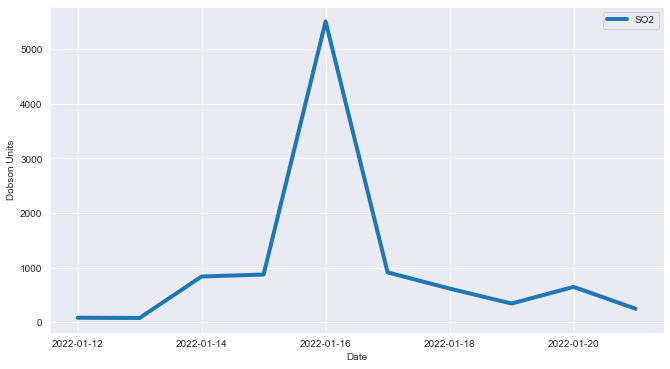

In [13]:
sns.set_style('darkgrid')
df_groupdate.plot(x='Date', y='SO2', figsize = (11,6), lw=4)

plt.legend(labels= ['SO2'])
plt.ylabel('Dobson Units')
plt.show()

#### Visualized with Scatterplots

With latitude, longitude, and SO2 columns, the DataFrame can be plotted as dots with colors in accordance with location and density. Let's start with creating a list of dates to filter the DataFrame. Only rows with SO2 more than 0.5 DU are selected to avoid the excessiveness of data when we plot them.

In [14]:
df = df_filtered

dates = list(set(list(df['Date'])))
dates.sort()
dates = dates[1:]    #remove January 11

df_plot = [df[(df['Date']==i) & (df['SO2'] > 0.5)] for i in dates]

Take the single day of Jan 17th as an example, let us make a scatter plot of the amount of SO2, a few days after the eruption.

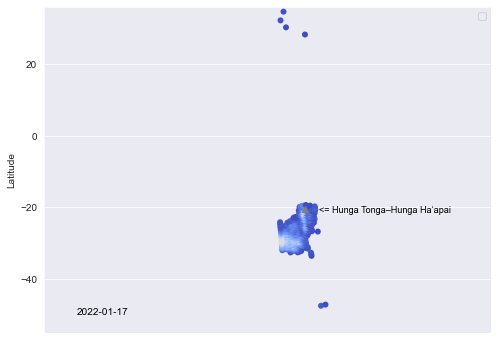

In [15]:
sns.set_style('darkgrid')
plt.figure(figsize=(8,6))

#scatter plot
g = sns.scatterplot(data=df_plot[5], x='Long', y='Lat',
                    palette='coolwarm', hue='SO2', linewidth=0.01,
                    hue_norm=(0.5,5.5))
g.set(xlim=(65, 270))
g.set(ylim=(-55, 36))

#plot Hunga Tonga–Hunga Haʻapai' location
plt.scatter(184.615, -20.55, color='gray', marker = '^')

#Hunga Tonga–Hunga Haʻapai' text
plt.text( 191, -21.5, '<= Hunga Tonga–Hunga Haʻapai', horizontalalignment='left',
         size=9, color='Black')

#date text
plt.text( 80, -50, '2022-01-17', horizontalalignment='left',
         size=10, color='Black')

plt.legend('')
plt.xlabel('')
plt.ylabel('Latitude')
plt.xticks([])
plt.show()

Now, we can successfully visualize the scatter plot of a single day, let's plot every daily scatter plot and store them in a list, then combine these daily plots into a GIF file to see the progress.

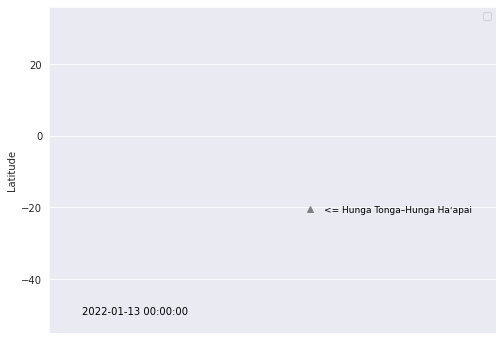

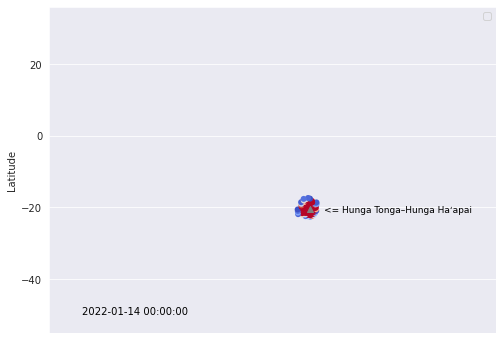

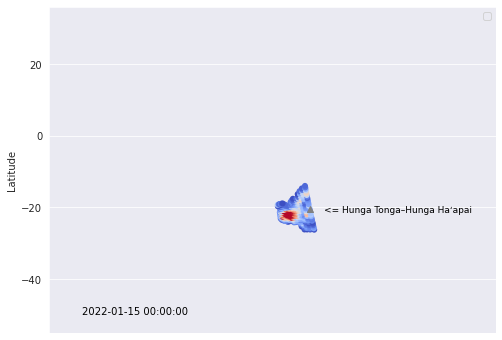

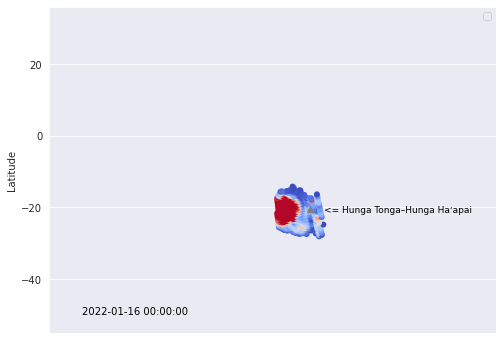

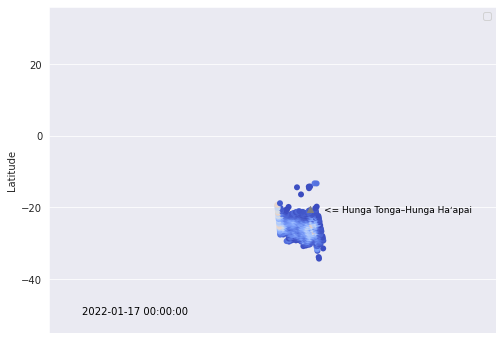

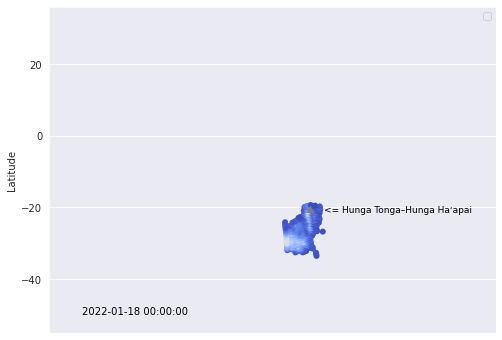

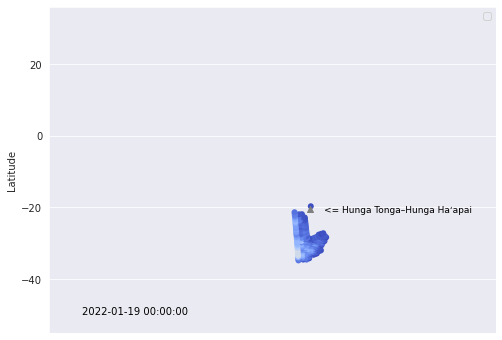

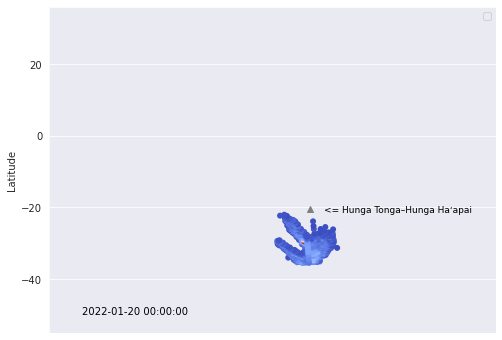

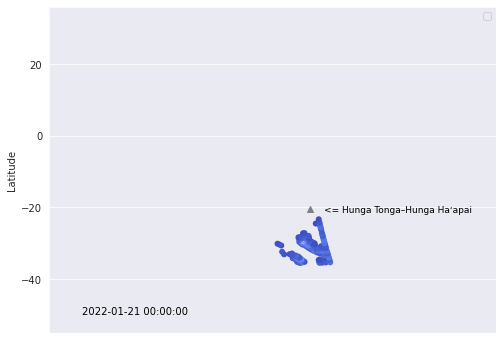

In [17]:
#create a list of numbers for use as saving name
save_order = [i+1 for i in list(range(len(df_plot)))]

for i,d,so in zip(df_plot, dates, save_order):
    sns.set_style('darkgrid')
    plt.figure(figsize=(8,6))
    
    #scatter plot
    g = sns.scatterplot(data=i, x='Long', y='Lat',
                        palette='coolwarm', hue='SO2', linewidth=0.01,
                        hue_norm=(0.5,5.5))
    g.set(xlim=(65, 270))
    g.set(ylim=(-55, 36))
    plt.legend('')
    
    #plot Hunga Tonga–Hunga Haʻapai' location
    plt.scatter(184.615, -20.55, color='gray', marker = '^')

    #Hunga Tonga–Hunga Haʻapai' text
    plt.text( 191, -21.5, '<= Hunga Tonga–Hunga Haʻapai', horizontalalignment='left',
             size=9, color='Black')

    #date text
    plt.text( 80, -50, d, horizontalalignment='left',
             size=10, color='Black')
    
    plt.title('')
    plt.xlabel('')
    plt.ylabel('Latitude')
    plt.xticks([])
    
    #export as PNG files, output location can be changed
    plt.savefig(str(so) + '.png', bbox_inches='tight',pad_inches = 0)
    plt.show()

In [18]:
from PIL import Image
import imageio

# read PNG files
img = []
for i in save_order[0:-1]:           
    myImage = Image.open(str(i) + ".png")
    img.append(myImage)

#export the GIF file, output location can be changed
imageio.mimsave('so2_2.gif', img, duration=0.3)

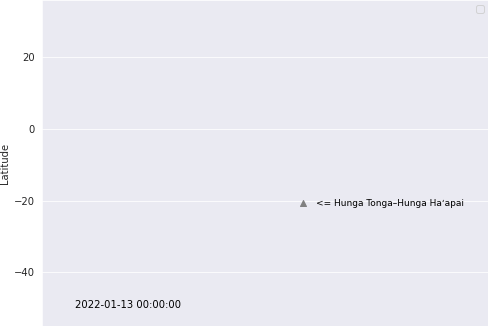

In [23]:
from IPython.display import Image
Image(data=open('so2_2.gif','rb').read(), format='png')

Now we have created local snapshots of the SO2 expansion over the area from Jan 13th to Jan 20th, 2022, let's explore further into how we can preserve the maps and data across organization. The ArcGIS API for Python also faciliates your publishing and storage of Web Layers and Web Maps onto ArcGIS Online organization or Enterprise.

#### Visualize with a heatmap


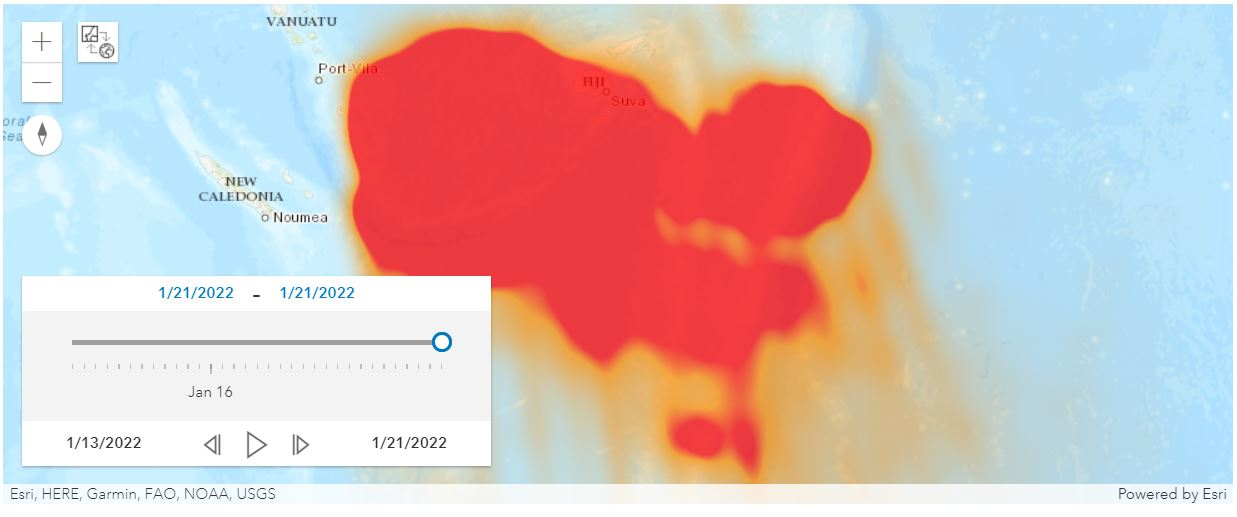

In [75]:
m1 = GIS().map(mode="2D")
m1.extent = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
             'xmin': -20601969.898812853,
             'ymin': -3220149.6465940434,
             'xmax': -18195120.752169862,
             'ymax': -2241755.684544048}
m1

A `Spatially Enabled DataFrame` in ArcGIS API for Python can be plotted in the map widget with the renderer set as `HeatMap`. Now we will use `SeDF.spatial.plot(...)` to render the SO2 amount as heat map, for the first day of the list.

In [117]:
this_frame = df_filtered[df_filtered['Date']=='2022-01-12']
this_frame.head()

,Lat,Long,SO2,Date,SHAPE
178449,-35.518738,198.319992,0.089305,2022-01-12,"{""spatialReference"": {""wkid"": 4326}, ""x"": 198...."
178479,-35.489803,192.233932,0.140721,2022-01-12,"{""spatialReference"": {""wkid"": 4326}, ""x"": 192...."
178481,-35.347752,193.794586,0.131881,2022-01-12,"{""spatialReference"": {""wkid"": 4326}, ""x"": 193...."
178482,-35.280327,194.688217,0.060800,2022-01-12,"{""spatialReference"": {""wkid"": 4326}, ""x"": 194...."
178484,-35.156765,196.815460,0.104824,2022-01-12,"{""spatialReference"": {""wkid"": 4326}, ""x"": 196...."


In [118]:
m1.clear_graphics()
this_frame.spatial.plot(map_widget = m1,
                        renderer_type='h', # specify the heatmap renderer using its notation 'h'
                        visual_variables={"blur_radius":30, "field":"SO2", "ratio":0.1},
                        alpha=0.75
                       )

True

Now rendering the 1st day is done, let's go through all days in the list and have the map widget render these maps in a sequence.

In [ ]:
import time

for i in dates:
    time.sleep(3)
    m1.clear_graphics()
    m1.remove_layers()
    new_frame = df_filtered[df_filtered['Date']==i]
    new_frame.spatial.plot( map_widget = m1,
                            renderer_type='h', # specify the heatmap renderer using its notation 'h'
                            visual_variables={"blur_radius":30, "field":"SO2", "ratio":0.1},
                            alpha=0.75
                           )
    print('Tonga_SO2_' + str(i))

An alternative approach is to add the FeatureLayer from remote GIS to local notebook, and view the time-specific heatmap display of the SO2 values via a time slider:

In [66]:
from datetime import datetime
m1.time_slider = True
m1.set_time_extent(start_time=datetime(2022,1,13), end_time=datetime(2022,1,21), interval=1, unit='days')

In [72]:
fl_item = gis.content.search("Tonga Volcano type:Feature Service")[0]
m1.remove_layers()
m1.add_layer(fl_item, {"renderer":"HeatmapRenderer",
                       "field": "SO2",
                       "opacity":0.75})

Last but not least, we can also view from the Web Map item being saved on our GIS instance:


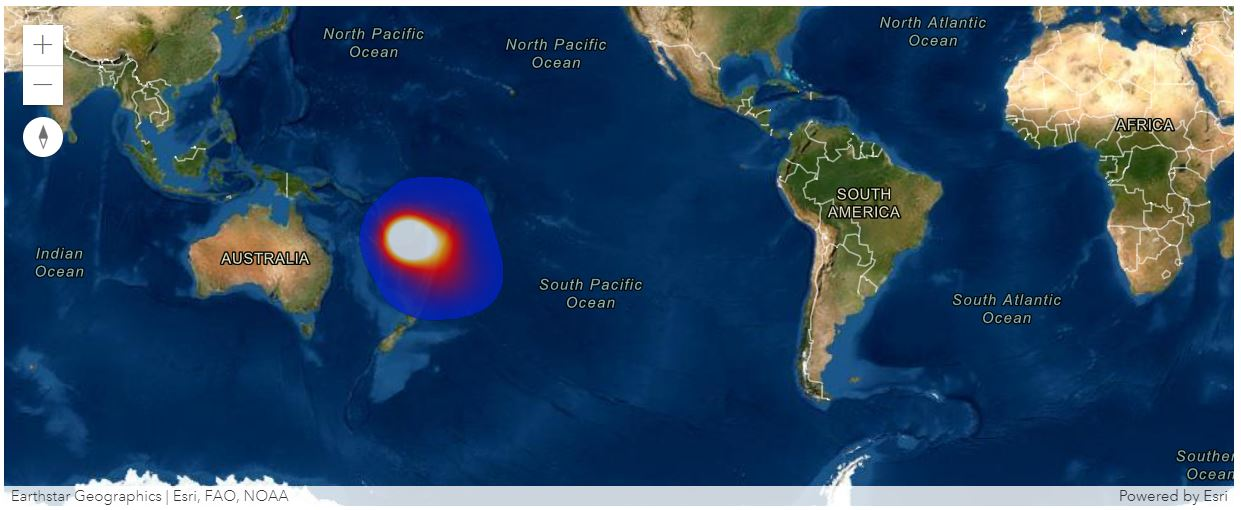

In [76]:
from arcgis.mapping import WebMap
wm_item = gis.content.search("Tonga Volcano Eruption")[0]
wm = WebMap(wm_item)
wm

## Summary

When facing natural disasters, human beings sometimes seem to be really vulnerable and helpless. The GIS and Science communities, though always trying to help with the monitoring and mitigation, are lack of real-time support and resources, e.g. in this case, in lack of real-time data to help monitor/predict the event, and later observe the CO2 and SO2 movement. 

This notebook has indicated, though SO2 is hard to observe with bare eyes, there are still ways to fetch information, visualize and analyze the volcano eruption events and SO2 releases with NASA and Maxar's data, and ArcGIS API for Python, seaborn, h5py, etc. as libraries.

## Reference

[1] CNN News Report, https://www.cnn.com/2022/01/24/asia/tonga-hiroshima-bomb-volcano-intl-hnk-scn-scli

[2] Earth Observatory Natural Event Tracker (EONET), https://eonet.gsfc.nasa.gov/what-is-eonet

[3] Bhanot, K. (2020, August 12). Getting NASA data for your next geo-project. Medium. Retrieved April 12, 2022, from https://towardsdatascience.com/getting-nasa-data-for-your-next-geo-project-9d621243b8f3

[4] Python-visualization. (2020). Folium. Retrieved from https://python-visualization.github.io/folium

[5] Agency for Toxic Substances and Disease Registry (ATSDR). 1998. Toxicological profile for Sulfur Dioxide. Atlanta, GA: U.S. Department of Health and Human Services, Public Health Service.

[6] Boriharn K, https://towardsdatascience.com/visualize-the-invisible-so2-with-nasa-data-and-python-2619f8ed4ea1

[7] Can Li, Nickolay A. Krotkov, Peter Leonard, Joanna Joiner (2020), OMPS/NPP PCA SO2 Total Column 1-Orbit L2 Swath 50x50km V2, Greenbelt, MD, USA, Goddard Earth Sciences Data and Information Services Center (GES DISC), Accessed: Mar 19, 2022, 10.5067/MEASURES/SO2/DATA205